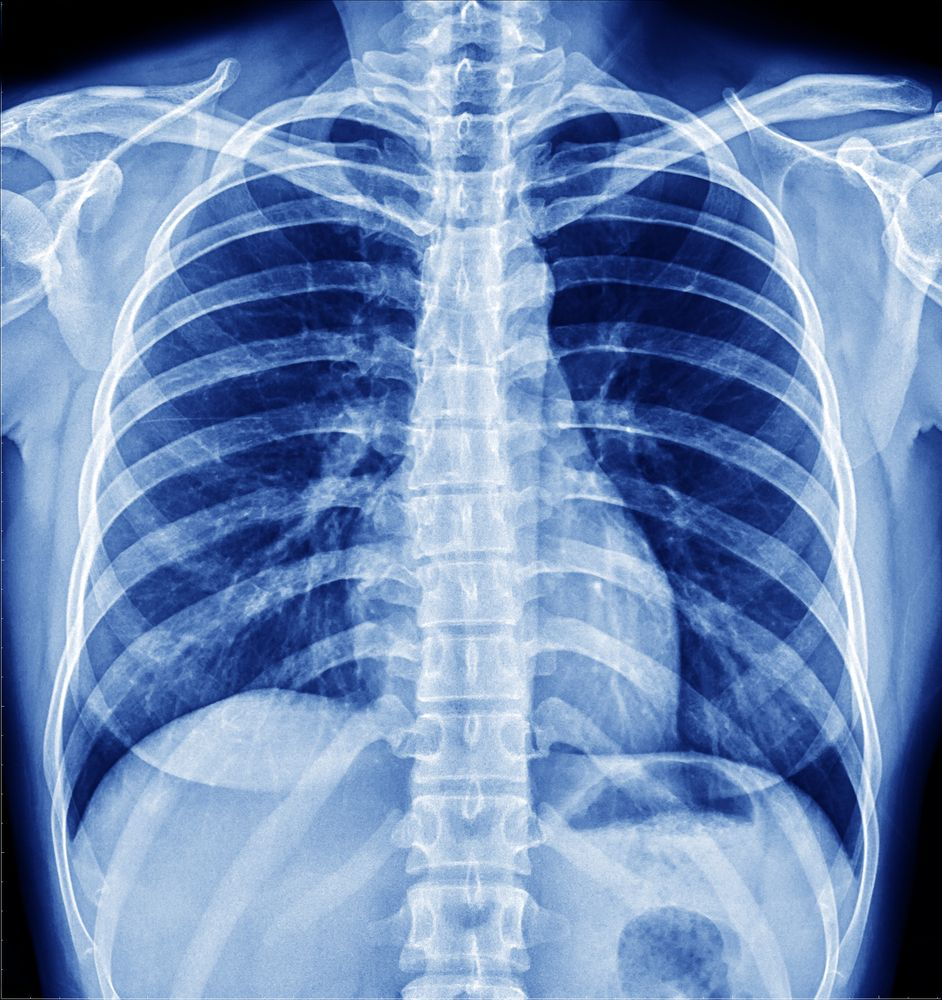

<span style="color:red;"><span style="font-size:15px;"><span style="font-weight:800;"><span style="font-size:15px;"> we can connect here😉 </span>   
[Let's Connect on LinkedIn!](https://www.linkedin.com/in/reza-mohit-6b1998218/)

<div style="color:yellow; 
            padding: 10px; 
            border-radius: 5px; 
            background-color: #002147; 
            font-size: 130%; 
            font-family: verdana; 
            letter-spacing: 0.5px;">

 <span style="font-size:23px;"><span style="font-weight:800;"><span style="color:white;"> 🎯    identification of Lung diseases with Chest X ray  </span><br>
     
  <span style="font-size:18px;"><span style="font-weight:800;"><span style="color:yellow;"> In this project, we focus on developing a convolutional neural network (CNN) model 
for the identification of Lung diseases throught Chest X ray.we have two classes normal and phenumonia.we try to train our model with 3 approaches... first without doing any specific changes on our data,second because we have an imbalance dataset we use oversampling method for minor class then train our model to see the results and last approach using Transfer learning. </span>
</div>
     

 <p style="padding:10px;background-color:orange;margin:200;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 1500px 500px;overflow:hidden;font-weight:8000">Thanks for supporting me by upvotes😍🤝</p>

 <p style="color:navy;font-family:newtimeroman;font-size:500%;text-align:center; font-weight:8000">🏁Lets get started🏁</p>

# <p style="padding:20px;background-color:black;margin:0;color:yellow;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 500px;overflow:hidden;font-weight:800">Step 1 | Setup and Initialization</p>

In [1]:
#import libraries
import torch
import os
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision
import seaborn as sns
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# <p style="padding:20px;background-color:black;margin:0;color:yellow;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 500px;overflow:hidden;font-weight:800">Step 2 | Dataset OverView</p>

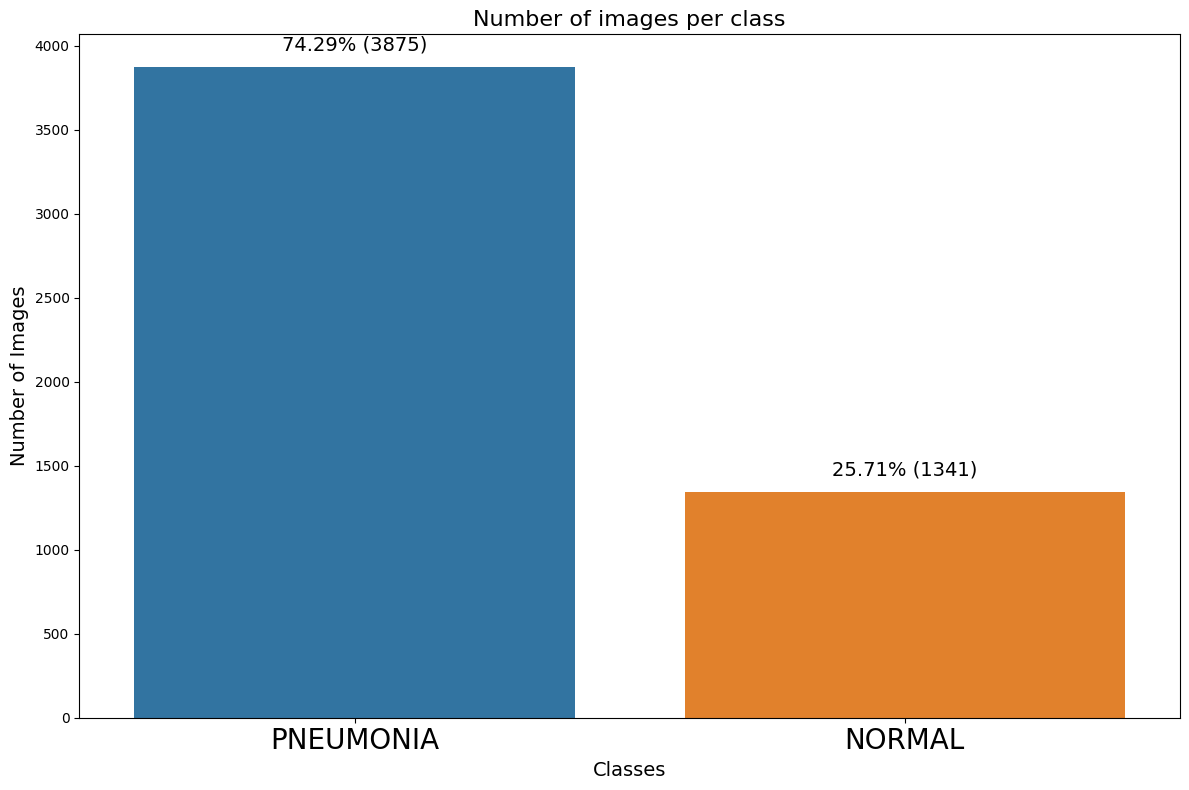

pretty imbalance


In [2]:
# Directory where the image folders are located
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'

# Obtain class names from the folder names in base_dir
classes = [folder_name for folder_name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder_name))]

# Counting the number of images in each folder
counts = []
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    counts.append(len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]))

# Calculating the total number of images
total_count = sum(counts)

# Calculating the percentages
percentages = [(count / total_count) * 100 for count in counts]

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a vertical bar plot with different colors for each bar
#colors = sns.color_palette('muted', len(classes))  # Colorful palette
ax = sns.barplot(x=classes, y=counts)

# Annotate each bar with the count and percentage
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100,  # Adjust position for annotation
            '{:1.2f}% ({})'.format(percentages[i], counts[i]),
            ha="center", fontsize=14)

# Set y-axis label and title
plt.ylabel('Number of Images', fontsize=14)
plt.xlabel('Classes', fontsize=14)
plt.title("Number of images per class", fontsize=16)
plt.xticks(fontsize=20)
# Show the plot
plt.tight_layout()
plt.show()
print('pretty imbalance')

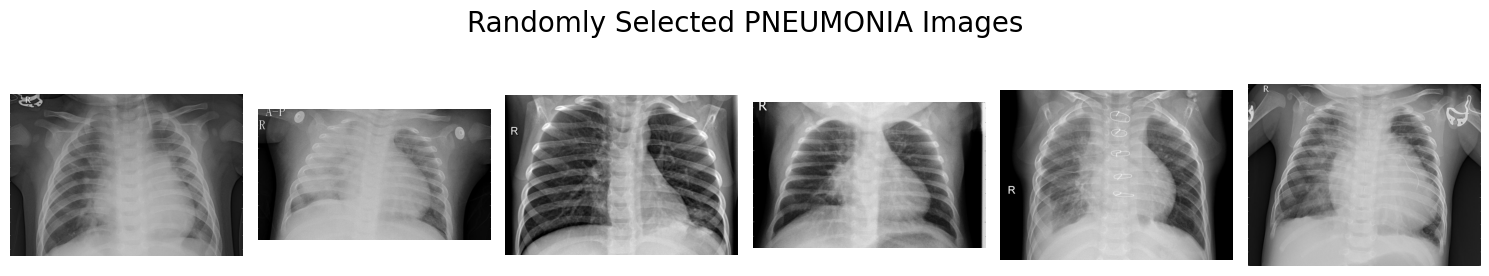

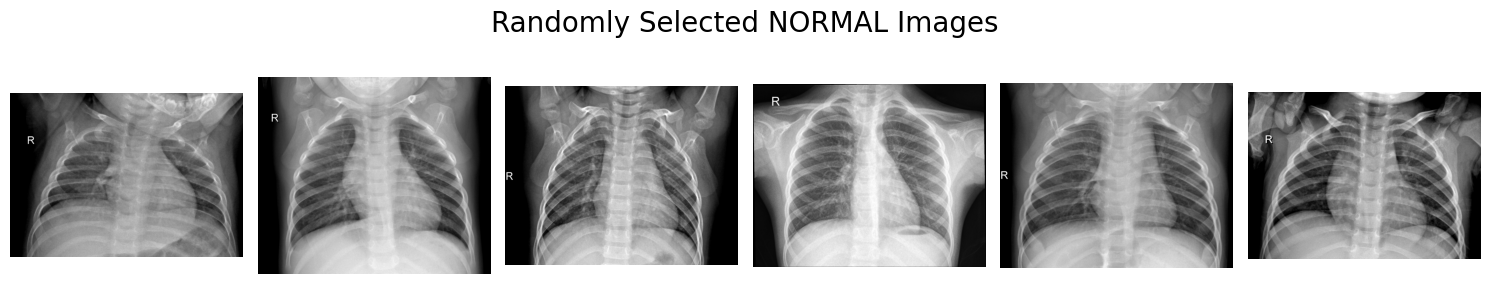

In [3]:
# Function to plot images
def plot_images(images, title):
    plt.figure(figsize=(15, 3)) 
    for i, img_path in enumerate(images):
        plt.subplot(1, 6, i+1)  # 1x5 subplot
        img = cv2.imread(img_path)
        # Convert the BGR image to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Setting the random seed for reproducibility
np.random.seed(42)

# Loop over each class and plot random images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images")

<div style="color:black; 
            padding: 10px; 
            border-radius: 5px; 
            background-color: #FFA500; 
            font-size: 130%; 
            font-family: newtimeroman;
            text-align:center;
            letter-spacing: 0.5px;">

     
  <span style="font-size:18px;"><span style="font-weight:800;"><span style="color:black;"> before starting we have to move few samples from normal and pneumonia class from train folder to validation,because validation folder has  very few samples </span>
</div>
     

In [4]:
import os
import shutil
from PIL import Image

# Define the source and destination directories
source_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
dest_dir = '/kaggle/working/train_images' 

# Create the destination directory
os.makedirs(dest_dir, exist_ok=True)

# Walk through the source directory and process each file
for root, dirs, files in os.walk(source_dir):
    # Create the same folder structure in the destination directory
    relative_path = os.path.relpath(root, source_dir)
    dest_subdir = os.path.join(dest_dir, relative_path)
    os.makedirs(dest_subdir, exist_ok=True)
    
    for file in files:
        file_path = os.path.join(root, file)
        
        # Check if the file has a .JPG extension
        if file.lower().endswith(".jpg") or file.lower().endswith(".jpeg"):
            new_filename = file.lower().replace(".jpeg", ".jpg").replace(".JPG", ".jpg")
            new_filepath = os.path.join(dest_subdir, new_filename)
            
            with Image.open(file_path) as img:
                img = img.convert("RGB")  # Ensure RGB format
                img.save(new_filepath, format="JPEG")
        else:
            # For other files, simply copy them to the destination
            shutil.copy(file_path, os.path.join(dest_subdir, file))

print(f"Successfully converted and copied images from {source_dir} to {dest_dir}.")


Successfully converted and copied images from /kaggle/input/chest-xray-pneumonia/chest_xray/train to /kaggle/working/train_images.



<span style="color:navy;"><span style="font-weight:800;"><span style="font-size:18px;"> 🔎moving valid samples to working enviroment so we can transfer samples from train to valid folder. </span>

In [5]:
import os
import shutil
from PIL import Image

# Define the source and destination directories
source_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/valid'
dest_dir = '/kaggle/working/valid_images' 

# Create the destination directory
os.makedirs(dest_dir, exist_ok=True)

# Walk through the source directory and process each file
for root, dirs, files in os.walk(source_dir):
    # Create the same folder structure in the destination directory
    relative_path = os.path.relpath(root, source_dir)
    dest_subdir = os.path.join(dest_dir, relative_path)
    os.makedirs(dest_subdir, exist_ok=True)
    
    for file in files:
        file_path = os.path.join(root, file)
        
        # Check if the file has a .JPG extension
        if file.lower().endswith(".jpg") or file.lower().endswith(".jpeg"):
            new_filename = file.lower().replace(".jpeg", ".jpg").replace(".JPG", ".jpg")
            new_filepath = os.path.join(dest_subdir, new_filename)
            
            # Convert if needed and save as .jpg in the destination directory
            with Image.open(file_path) as img:
                img = img.convert("RGB")  # Ensure RGB format
                img.save(new_filepath, format="JPEG")
        else:
            shutil.copy(file_path, os.path.join(dest_subdir, file))

print(f"Successfully converted and copied images from {source_dir} to {dest_dir}.")


Successfully converted and copied images from /kaggle/input/chest-xray-pneumonia/chest_xray/valid to /kaggle/working/valid_images.



<span style="color:navy;"><span style="font-weight:800;"><span style="font-size:18px;"> Transfer data from train folder to valid folder. </span>

In [6]:
import os
import shutil
import random

# Define source and destination directories
source_dir = '/kaggle/working/train_images'
destination_dir = '/kaggle/working/valid_images'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Collect the class folders and image counts
class_image_counts = {}
for class_folder in os.listdir(source_dir):
    class_folder_path = os.path.join(source_dir, class_folder)
    if os.path.isdir(class_folder_path):
        # Count images in each class
        image_files = [f for f in os.listdir(class_folder_path) if os.path.isfile(os.path.join(class_folder_path, f))]
        class_image_counts[class_folder] = len(image_files)

# Calculate target validation size based on the smallest class
min_class_size = min(class_image_counts.values())
validation_size_per_class = max(1, int(min_class_size * 0.1))

# Move images to maintain balance
for class_folder, image_count in class_image_counts.items():
    class_folder_path = os.path.join(source_dir, class_folder)
    destination_class_folder = os.path.join(destination_dir, class_folder)
    os.makedirs(destination_class_folder, exist_ok=True)
    
    # Calculate the number of images to move
    if image_count == min_class_size:
        num_images_to_move = validation_size_per_class
    else:
        num_images_to_move = validation_size_per_class  # Adjust to balance
    
    # Get and randomly select images to move
    image_files = [f for f in os.listdir(class_folder_path) if os.path.isfile(os.path.join(class_folder_path, f))]
    images_to_move = random.sample(image_files, num_images_to_move)
    
    # Move selected images to the destination folder
    for image_file in images_to_move:
        source_file = os.path.join(class_folder_path, image_file)
        destination_file = os.path.join(destination_class_folder, image_file)
        shutil.move(source_file, destination_file)

print("Balanced subset of images has been moved to the destination directory.")


Balanced subset of images has been moved to the destination directory.


<div style="color:black; 
            padding: 10px; 
            border-radius: 5px; 
            background-color: #FFFF00; 
            font-size: 130%; 
            font-family: newtimeroman;
            text-align:center;
            letter-spacing: 0.5px;">

     
  <span style="font-size:18px;"><span style="font-weight:800;"><span style="color:black;"> Approch 1: we start building just a simple cnn without changing anything.
 and see what will happen to accuracy and specially F1socre and confusion matrix, when we have an imbalance dataset </span>
</div>
     

# <p style="padding:20px;background-color:black;margin:0;color:yellow;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 500px;overflow:hidden;font-weight:800">Step 3 | simple CNN Modeling</p>

In [7]:
# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load your custom dataset
trainset = ImageFolder(root='/kaggle/working/train_images', transform=transform)
train = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

# If you have a validation or test set, do the same for it
valset = ImageFolder(root='/kaggle/working/valid_images', transform=transform)
valid = DataLoader(valset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
print(trainset.classes)
print(valset.classes)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


<span style="color:navy;"><span style="font-weight:800;"><span style="font-size:18px;"> 🔎checking images resolutions. </span>

In [8]:
data_iter = iter(train)
images, labels = next(data_iter)

# Print the shape of images and labels in the batch
print(f"Image batch dimensions: {images.shape}")
print(f"Label batch dimensions: {labels.shape}")

# Optionally, print the dimensions of each image in the batch
for i, img in enumerate(images):
    print(f"Image {i+1} dimensions: {img.shape}")

Image batch dimensions: torch.Size([32, 3, 256, 256])
Label batch dimensions: torch.Size([32])
Image 1 dimensions: torch.Size([3, 256, 256])
Image 2 dimensions: torch.Size([3, 256, 256])
Image 3 dimensions: torch.Size([3, 256, 256])
Image 4 dimensions: torch.Size([3, 256, 256])
Image 5 dimensions: torch.Size([3, 256, 256])
Image 6 dimensions: torch.Size([3, 256, 256])
Image 7 dimensions: torch.Size([3, 256, 256])
Image 8 dimensions: torch.Size([3, 256, 256])
Image 9 dimensions: torch.Size([3, 256, 256])
Image 10 dimensions: torch.Size([3, 256, 256])
Image 11 dimensions: torch.Size([3, 256, 256])
Image 12 dimensions: torch.Size([3, 256, 256])
Image 13 dimensions: torch.Size([3, 256, 256])
Image 14 dimensions: torch.Size([3, 256, 256])
Image 15 dimensions: torch.Size([3, 256, 256])
Image 16 dimensions: torch.Size([3, 256, 256])
Image 17 dimensions: torch.Size([3, 256, 256])
Image 18 dimensions: torch.Size([3, 256, 256])
Image 19 dimensions: torch.Size([3, 256, 256])
Image 20 dimensions: 

<span style="color:navy;"><span style="font-weight:800;"><span style="font-size:18px;"> 🔎Simple CNN architecture. </span>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Single convolutional layer with batch normalization and pooling
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)  # Reduces dimensions by half (128x128 )

        # Fully connected layers 
        self.fc1 = nn.Linear(32 * 128 * 128, 512)  
        self.fc2 = nn.Linear(512, 1)  # Output size for binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F  # For softmax

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 15

# Early Stopping Class with Restore Best Weights Option and Best Epoch Tracking
class EarlyStopping:
    def __init__(self, patience=10, verbose=1, min_delta=0.001, mode='min', restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.restore_best_weights = restore_best_weights
        self.best_model_weights = None  # To store the best model weights
        self.best_epoch = 0  # To track the best epoch

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict()  # Save initial model state
            self.best_epoch = epoch
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict()  # Save best model state
            self.best_epoch = epoch  # Update best epoch
            self.counter = 0  # Reset counter if there's an improvement
        else:
            self.counter += 1  # Increment if no improvement
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    print(f"Restoring model weights from the end of the best epoch: {self.best_epoch + 1}.")
                    model.load_state_dict(self.best_model_weights)

# Initialize early stopping and learning rate scheduler
early_stopping = EarlyStopping(patience=8, min_delta=0.001)

# Wrap model in DataParallel for multi-GPU usage


# Ensure the optimizer and scheduler are correctly set after DataParallel
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, verbose=1, steps_per_epoch=len(train), epochs=num_epochs)

best_val_loss = float('inf')  # For saving the best model based on validation loss

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (inputs, targets) in enumerate(train):
        inputs = inputs.to(device)
        targets = targets.float().view(-1, 1).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy for training
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
        
        # Print intermediate loss and accuracy every 32 batches
        if i % 32 == 0:
            batch_accuracy = 100 * correct_train / total_train
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train)}, Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.2f}%")
    
    # End of epoch training accuracy and loss
    epoch_train_loss = running_loss / len(train)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid:
            inputs = inputs.to(device)
            labels = labels.float().view(-1, 1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy (categorical accuracy)
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Average validation loss and accuracy for the epoch
    epoch_val_loss = val_loss / len(valid)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%")
    
    # Save the best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss

    # Step the learning rate scheduler
    scheduler.step(epoch_val_loss)

    # Early stopping check and restore weights if triggered
    early_stopping(epoch_val_loss, model, epoch)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# After training, print the best epoch if early stopping was not triggered
if not early_stopping.early_stop and early_stopping.restore_best_weights:
    print(f"Training completed. Restoring model weights from the end of the best epoch: {early_stopping.best_epoch + 1}.")
    model.load_state_dict(early_stopping.best_model_weights)


Epoch 1, Batch 1/155, Loss: 0.7106, Accuracy: 18.75%
Epoch 1, Batch 33/155, Loss: 0.5505, Accuracy: 81.53%
Epoch 1, Batch 65/155, Loss: 1.2944, Accuracy: 87.21%
Epoch 1, Batch 97/155, Loss: 0.1528, Accuracy: 89.63%
Epoch 1, Batch 129/155, Loss: 0.0014, Accuracy: 91.11%
Epoch 1/15, Train Loss: 2.7411, Train Accuracy: 91.67%, Val Loss: 0.6364, Val Accuracy: 95.15%
Epoch 2, Batch 1/155, Loss: 0.5921, Accuracy: 93.75%
Epoch 2, Batch 33/155, Loss: 0.2634, Accuracy: 96.12%
Epoch 2, Batch 65/155, Loss: 0.0748, Accuracy: 96.11%
Epoch 2, Batch 97/155, Loss: 0.2395, Accuracy: 96.33%
Epoch 2, Batch 129/155, Loss: 0.0076, Accuracy: 95.93%
Epoch 2/15, Train Loss: 0.3058, Train Accuracy: 95.63%, Val Loss: 1.5780, Val Accuracy: 88.43%
Epoch 3, Batch 1/155, Loss: 0.5047, Accuracy: 96.88%
Epoch 3, Batch 33/155, Loss: 0.0717, Accuracy: 97.92%
Epoch 3, Batch 65/155, Loss: 0.0014, Accuracy: 97.60%
Epoch 3, Batch 97/155, Loss: 0.0004, Accuracy: 96.84%
Epoch 3, Batch 129/155, Loss: 0.0760, Accuracy: 97.02%


In [12]:
print("Train Losses:", train_losses)
print("Validation Losses:", val_losses)
print("Train Accuracies:", train_accuracies)
print("Validation Accuracies:", val_accuracies)

Train Losses: [2.741070333257431, 0.3057648137348057, 0.17059348326958407, 0.07374203948439169, 0.02796960318366827, 0.07415208437709457, 0.0585689120002546, 0.032824830014415704, 0.03432675863011434, 0.0066188176832844585, 0.04017939430597866, 0.02766267009708106, 0.009895446770212656, 0.00571969862419859, 0.00010674619979291469]
Validation Losses: [0.6363968456368335, 1.5779657335243575, 0.42878518378125186, 0.7365722230846516, 0.4286474160489888, 0.4952863483000935, 1.3166497358253038, 0.553128910596506, 0.4666640953946626, 0.39429556949551015, 0.5929040298602423, 0.3932456746697426, 0.2805357435394803, 0.313103789360159, 0.3465213125519868]
Train Accuracies: [91.67340339531124, 95.63459983831851, 97.1301535974131, 98.464025869038, 99.0501212611156, 98.40339531123686, 98.74696847210994, 99.11075181891674, 99.13096200485045, 99.71705739692806, 99.09054163298302, 99.33306386418755, 99.63621665319322, 99.89894907033144, 100.0]
Validation Accuracies: [95.14925373134328, 88.4328358208955

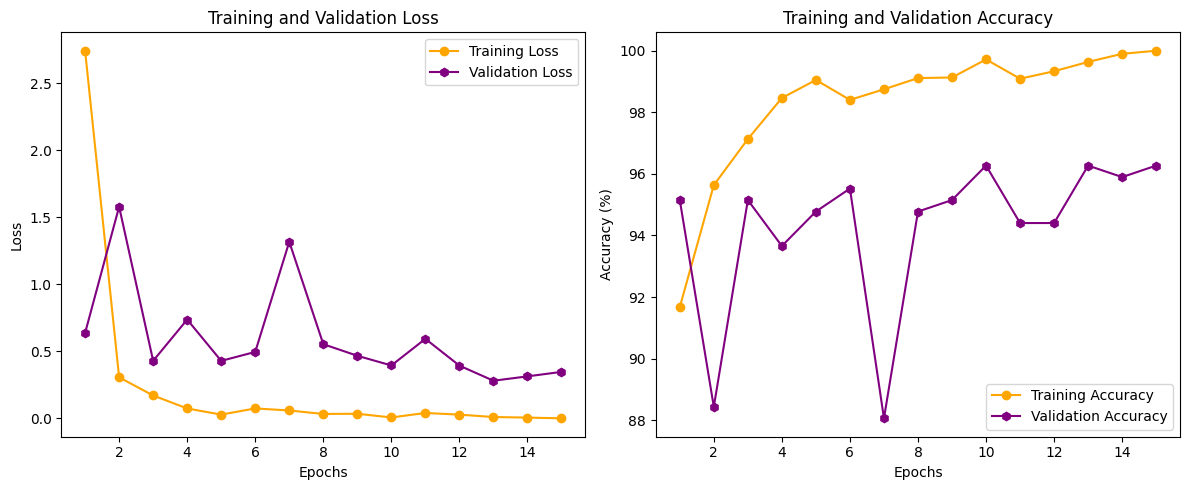

In [13]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss',color='orange', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss',color='purple', marker='h')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy',color='orange', marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy',color='purple', marker='h')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


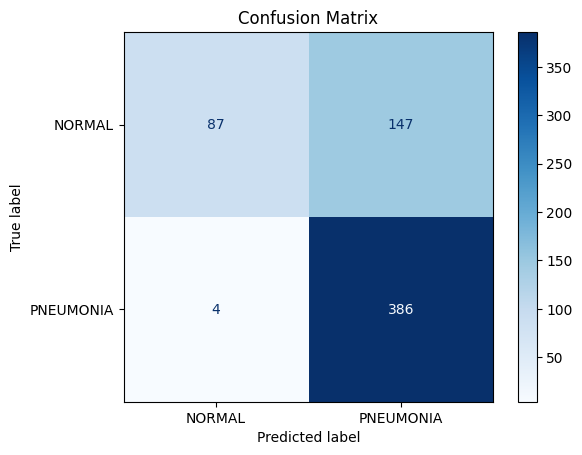

              precision    recall  f1-score   support

      NORMAL       0.96      0.37      0.54       234
   PNEUMONIA       0.72      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.68      0.69       624
weighted avg       0.81      0.76      0.72       624



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report


testset = ImageFolder(root='/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

# Switch the model to evaluation mode
model.eval()

# Collect true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        preds = (outputs > 0.7).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Convert lists to numpy arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(all_labels, all_preds, target_names=testset.classes))

<div style="color:black; 
            padding: 10px; 
            border-radius: 5px; 
            background-color: #FFA500; 
            font-size: 130%; 
            font-family: newtimeroman;
            text-align:center;
            letter-spacing: 0.5px;">

     
  <span style="font-size:18px;"><span style="font-weight:800;"><span style="color:black;"> as you can see the result is awful!we need to rebuild whole model in a diffrent way </span>
</div>
     

# <p style="padding:20px;background-color:black;margin:0;color:yellow;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 500px;overflow:hidden;font-weight:800">Step 4 | Grad_CAM</p>

<span style="color:navy;"><span style="font-weight:800;"><span style="font-size:18px;"> 🔎GRAD_CAM is a method to show us where exactly our model 'LOOKING at' in other word you can monitor your model to understand how and by looking at which point of image,its predicting the result . </span>

In [15]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00


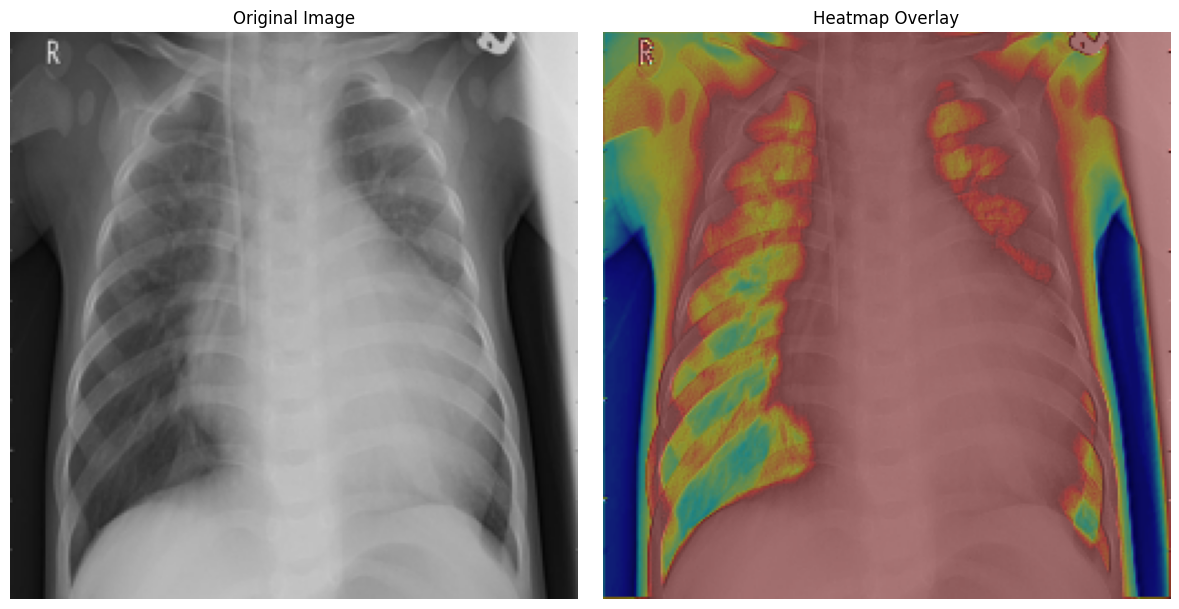

In [18]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp


def overlay_heatmap_with_box(image, cam, threshold=0.6):
    # Resize and normalize heatmap
    heatmap = cv2.resize(cam, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convert to range [0, 255]
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on the original image
    overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    return overlay


def generate_grad_cam(model, image_tensor, class_idx, device):
    # Ensure the model is in evaluation mode
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Hook for gradients
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks
    target_layer = model.conv1  # Use the first convolutional layer as an example
    forward_hook_handle = target_layer.register_forward_hook(forward_hook)
    backward_hook_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image_tensor)
    target = output[:, class_idx]

    # Backward pass
    model.zero_grad()
    target.backward()

    # Compute Grad-CAM
    gradients = gradients[0].cpu().detach().numpy()
    activations = activations[0].cpu().detach().numpy()

    weights = np.mean(gradients, axis=(2, 3))  # Global average pooling on gradients
    cam = np.sum(weights[:, :, None, None] * activations, axis=1)
    cam = np.maximum(cam, 0)  # ReLU to keep only positive values
    cam = cam[0]  # Remove batch dimension

    # Normalize CAM to range [0, 1]
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.clip(cam, 0, 1)  # Ensure values stay in [0, 1]

    # Remove hooks
    forward_hook_handle.remove()
    backward_hook_handle.remove()

    return cam


def preprocess_image(image_path, target_size=(256, 256)):
    # Load and process the image
    raw_image = cv2.imread(image_path)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

    # Resize the image to the target size
    resized_image = cv2.resize(raw_image, target_size)

    # Normalize the image for the model
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(resized_image)
    return image_tensor, resized_image


def visualize_with_grad_cam_side_by_side(model, image_path, class_idx, device):
    # Load and preprocess the image
    image_tensor, raw_image = preprocess_image(image_path)

    # Generate Grad-CAM
    cam = generate_grad_cam(model, image_tensor, class_idx, device)

    # Overlay heatmap
    heatmap_overlay = overlay_heatmap_with_box(raw_image, cam)

    # Load original image using PIL
    original_image = Image.open(image_path).resize((224, 224))

    # Plot side-by-side images
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    ax0.imshow(original_image)
    ax0.set_title("Original Image")
    ax0.axis('off')

    # Heatmap overlay
    ax1.imshow(heatmap_overlay)
    ax1.set_title("Heatmap Overlay")
    ax1.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
model.eval()

# Path to an image from your dataset
image_path = "/kaggle/working/train_images/PNEUMONIA/person1034_bacteria_2968.jpg"

# Visualize Grad-CAM side by side with the original image
visualize_with_grad_cam_side_by_side(model, image_path, class_idx=0, device=device)


<div style="color:black; 
            padding: 10px; 
            border-radius: 5px; 
            background-color: #000000; 
            font-size: 130%; 
            font-family: newtimeroman;
            text-align:center;
            letter-spacing: 0.5px;">

     
  <span style="font-size:18px;"><span style="font-weight:800;"><span style="color:red;"> Important note:Grad-CAM is not predicting results or providing a diagnosis. It is simply a method to visualize which areas of the input image CNN model focuses on to separate classes from each other during its predictions.the HOT areas are the specific parts that our model predicting the results based on looking at them </span>
</div>
     

In [19]:
torch.cuda.empty_cache()

# <p style="padding:20px;background-color:black;margin:0;color:yellow;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 500px;overflow:hidden;font-weight:800">Step 5 | Custome CNN </p>

<div style="color:black; 
            padding: 10px; 
            border-radius: 5px; 
            background-color: #FFFF00; 
            font-size: 130%; 
            font-family: newtimeroman;
            text-align:center;
            letter-spacing: 0.5px;">

     
  <span style="font-size:18px;"><span style="font-weight:800;"><span style="color:black;"> Approch 2: in this part we change our preprocessing method,we resize our images,add blue,gaussian noise and other methods for more realistic changes in train images in order to have more better results on unseen datas . and also we will use oversampling method for balancing our classes to achive better f1score </span>
</div>
     

In [35]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np


# Define Albumentations augmentations
def augment_image(image):
    aug = A.Compose([
        A.Resize(256, 256),  # Resize images to a slightly larger size
        A.CenterCrop(224, 224),  # Crop the central part
        A.CLAHE(clip_limit=4.0, p=0.5),  # Improve contrast
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4),  # Adjust color properties
        A.Blur(blur_limit=3, p=0.3),  # Apply slight blur for robustness
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Add Gaussian noise
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
        ToTensorV2()  # Convert to PyTorch tensor
    ])
    augmented = aug(image=image)
    return augmented['image']


class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)  # Convert PIL to NumPy
        img = augment_image(img)
        return img, label
        

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224*224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Paths to datasets
train_path = '/kaggle/working/train_images'
val_path = '/kaggle/working/valid_images'
test_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# Load datasets with Albumentations
trainset = AlbumentationsDataset(ImageFolder(root=train_path))
valset = ImageFolder(root=val_path,transform=transform)
testset = ImageFolder(root=test_path,transform=transform)

# Calculate class weights for oversampling
train_labels = [label for _, label in trainset]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts  # Weight inversely proportional to class frequency
weights = [class_weights[label] for label in train_labels]

# Create a WeightedRandomSampler for oversampling
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoaders
train = DataLoader(trainset, batch_size=64, sampler=sampler, num_workers=4, pin_memory=True)
valid = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

print("DataLoaders created with oversampling for training.")

DataLoaders created with oversampling for training.


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layers with Batch Normalization and Dropout
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)  # Dropout after the first layer

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)  # Dropout after the second layer

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)  # Dropout after the third layer

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout2d(0.25)  # Dropout after the fourth layer

        # Fully connected layers with Batch Normalization and Dropout
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn_fc = nn.BatchNorm1d(512)
        self.dropout_fc = nn.Dropout(0.5)  # Dropout for fully connected layer
        self.fc2 = nn.Linear(512, 1)  # Binary classification

    def forward(self, x):
        # Apply each conv, batch norm, activation, pool, and dropout layer sequentially
        x = self.pool1(self.dropout1(torch.relu(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(torch.relu(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(torch.relu(self.bn3(self.conv3(x)))))
        x = self.pool4(self.dropout4(torch.relu(self.bn4(self.conv4(x)))))

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = torch.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout_fc(x)  # Dropout after first fully connected layer
        x = self.fc2(x)  # Output layer, raw scores for each class

        return x


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [38]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F  # For softmax

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 10

# Early Stopping Class with Restore Best Weights Option and Best Epoch Tracking
class EarlyStopping:
    def __init__(self, patience=20, verbose=1, min_delta=0.001, mode='min', restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.restore_best_weights = restore_best_weights
        self.best_model_weights = None  # To store the best model weights
        self.best_epoch = 0  # To track the best epoch

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict()  # Save initial model state
            self.best_epoch = epoch
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict()  # Save best model state
            self.best_epoch = epoch  # Update best epoch
            self.counter = 0  # Reset counter if there's an improvement
        else:
            self.counter += 1  # Increment if no improvement
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    print(f"Restoring model weights from the end of the best epoch: {self.best_epoch + 1}.")
                    model.load_state_dict(self.best_model_weights)

# Initialize early stopping and learning rate scheduler
early_stopping = EarlyStopping(patience=8, min_delta=0.001)

# Wrap model in DataParallel for multi-GPU usage
model = nn.DataParallel(model)  # Add this to utilize multiple GPUs
model = model.to(device)

# Ensure the optimizer and scheduler are correctly set after DataParallel
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, verbose=1, steps_per_epoch=len(train), epochs=num_epochs)

best_val_loss = float('inf')  # For saving the best model based on validation loss

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (inputs, targets) in enumerate(train):
        inputs = inputs.to(device)
        targets = targets.float().view(-1, 1).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy for training
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
        
        # Print intermediate loss and accuracy every 32 batches
        if i % 32 == 0:
            batch_accuracy = 100 * correct_train / total_train
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train)}, Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.2f}%")
    
    # End of epoch training accuracy and loss
    epoch_train_loss = running_loss / len(train)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid:
            inputs = inputs.to(device)
            labels = labels.float().view(-1, 1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy (categorical accuracy)
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Average validation loss and accuracy for the epoch
    epoch_val_loss = val_loss / len(valid)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%")
    
    # Save the best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss


    # Early stopping check and restore weights if triggered
    early_stopping(epoch_val_loss, model, epoch)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# After training, print the best epoch if early stopping was not triggered
if not early_stopping.early_stop and early_stopping.restore_best_weights:
    print(f"Training completed. Restoring model weights from the end of the best epoch: {early_stopping.best_epoch + 1}.")
    model.load_state_dict(early_stopping.best_model_weights)


Epoch 1, Batch 1/78, Loss: 0.7180, Accuracy: 40.62%
Epoch 1, Batch 33/78, Loss: 0.3412, Accuracy: 74.67%
Epoch 1, Batch 65/78, Loss: 0.1898, Accuracy: 81.08%
Epoch 1/10, Train Loss: 0.3706, Train Accuracy: 82.72%, Val Loss: 0.5761, Val Accuracy: 71.27%
Epoch 2, Batch 1/78, Loss: 0.2016, Accuracy: 89.06%
Epoch 2, Batch 33/78, Loss: 0.2378, Accuracy: 89.39%
Epoch 2, Batch 65/78, Loss: 0.2043, Accuracy: 90.26%
Epoch 2/10, Train Loss: 0.2248, Train Accuracy: 90.34%, Val Loss: 0.3935, Val Accuracy: 83.96%
Epoch 3, Batch 1/78, Loss: 0.2270, Accuracy: 90.62%
Epoch 3, Batch 33/78, Loss: 0.1411, Accuracy: 91.86%
Epoch 3, Batch 65/78, Loss: 0.1483, Accuracy: 91.66%
Epoch 3/10, Train Loss: 0.2037, Train Accuracy: 91.55%, Val Loss: 0.4586, Val Accuracy: 80.60%
Epoch 4, Batch 1/78, Loss: 0.2505, Accuracy: 87.50%
Epoch 4, Batch 33/78, Loss: 0.2157, Accuracy: 92.14%
Epoch 4, Batch 65/78, Loss: 0.2214, Accuracy: 92.14%
Epoch 4/10, Train Loss: 0.1792, Train Accuracy: 92.30%, Val Loss: 0.4545, Val Accur

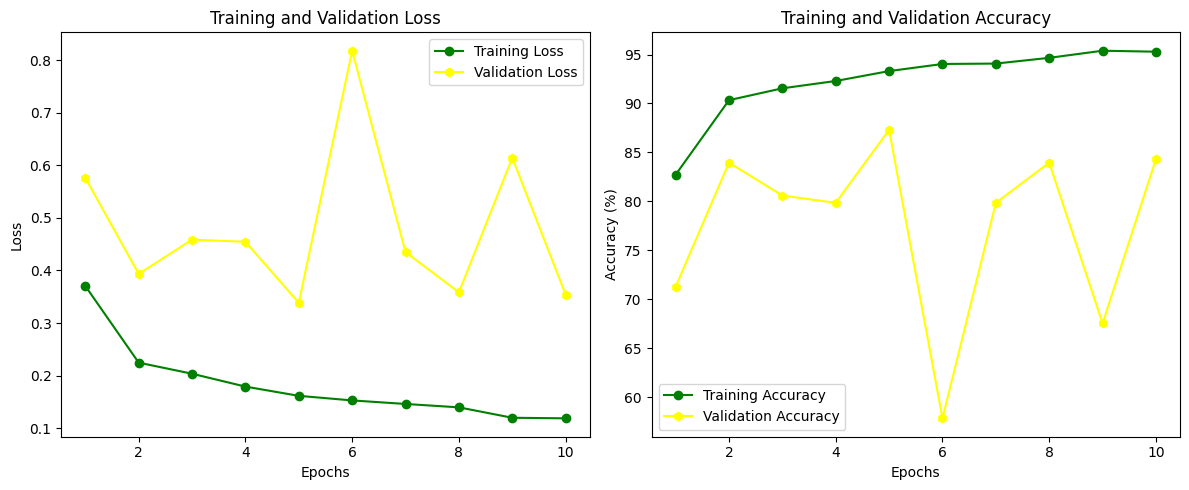

In [39]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss',color='green', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss',color='yellow', marker='h')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy',color='green', marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy',color='yellow', marker='h')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


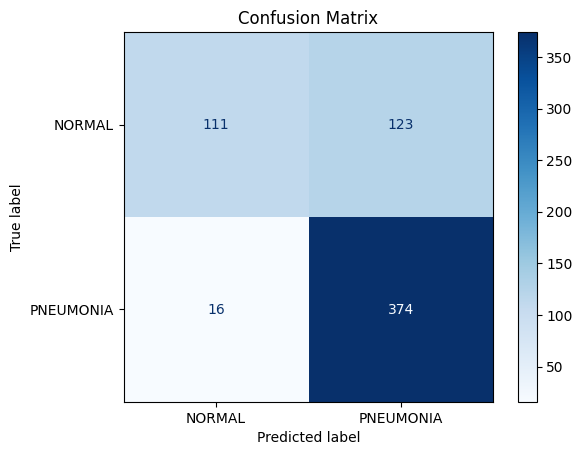

              precision    recall  f1-score   support

      Normal       0.87      0.47      0.61       234
   Pneumonia       0.75      0.96      0.84       390

    accuracy                           0.78       624
   macro avg       0.81      0.72      0.73       624
weighted avg       0.80      0.78      0.76       624



In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Switch the model to evaluation mode
model.eval()

# Collect true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        preds = (outputs > 0.7).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Convert lists to numpy arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class AlbumentationsDataset(Dataset):
    def __init__(self, filepaths, labels, augment_function, class_names=None):
        self.filepaths = filepaths
        self.labels = labels
        self.augment_function = augment_function
        self.classes = class_names  # Class names for evaluation

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        label = self.labels[idx]

        # Apply augmentations
        if self.augment_function:
            image = self.augment_function(image=np.array(image))  # Call the provided augment function

        return image, label


class_names = ['Normal', 'Pneumonia']  # Replace with actual class names

testset = AlbumentationsDataset(
    filepaths=test_path,  # Paths to test images
    labels=labels,        # Corresponding labels
    augment_function=augment_image,  # Use your defined function
    class_names=class_names
)

from sklearn.metrics import classification_report

# Evaluate the model and populate predictions
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=testset.classes))


In [ ]:
torch.cuda.empty_cache()  # Free up GPU memory cache

<div style="color:black; 
            padding: 10px; 
            border-radius: 5px; 
            background-color: #FFA500; 
            font-size: 130%; 
            font-family: newtimeroman;
            text-align:center;
            letter-spacing: 0.5px;">

     
  <span style="font-size:18px;"><span style="font-weight:800;"><span style="color:black;"> Very important note<br>
1.when we are use augmentations like Blur,noise rotation and etc on our data,the goal is to stimulate real world senarios for our model for better generalization on unseen datas.but if you use heavy augmentations on your datas,your model learn the pattern in the wrong way! for example if you use too much blur and downgrade or rotation on images,your model can learn the pattern in training but the result on validation and test data wil be awful because you force your model to learn unrealistic changes that doesnt actually exist in test and validation images .thats why despite of using much more complex layer ,we recived worse results.
<br><br>
2.another point is NEVER apply augmetaions like blur ,noise and etc on VALID and TEST data .beacause the evalutaions would be fake!and its like cheating.only apply normalization and resize on your test and valid data </span>
</div>
     

# <p style="padding:20px;background-color:black;margin:0;color:yellow;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 500px;overflow:hidden;font-weight:800">Step 6 | Transfer Learning </p>

<div style="color:black; 
            padding: 10px; 
            border-radius: 5px; 
            background-color: #AC9900; 
            font-size: 130%; 
            font-family: newtimeroman;
            text-align:center;
            letter-spacing: 0.5px;">

     
  <span style="font-size:18px;"><span style="font-weight:800;"><span style="color:black;"> so i decided to use another path.i will use augmentation on my data but instead on appling on my whole images on train folder,i just use 50% on them and apply DOWNGRADE,BLUR and GAUSSIAN NOISE,on them and add the generated images on the original train folder.with this approach ,my model can learn both normal and augmentated images,so it will have a better generalization on unseen and futures datas.but beware that if you add too many augmatated images in your train folder,like previous approach ,your model falls into a trap and learn a fake pattern that doesnt exist in unseen datas. </span>
</div>
     

In [7]:
import os
import random
from pathlib import Path
import cv2
import numpy as np
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import Counter
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

# Paths to datasets
train_path = '/kaggle/working/train_images'
augmented_path = '/kaggle/working/BRAIN_MRI/train_augmented'
val_path = '/kaggle/working/valid_images'

# Ensure the augmented directory exists
Path(augmented_path).mkdir(parents=True, exist_ok=True)

# Albumentations augmentations for synthetic data
blur_transform = A.Compose([A.Blur(blur_limit=7)])
noise_transform = A.Compose([A.GaussNoise(var_limit=(10, 50))])
downsample = A.Compose([
    A.Resize(128, 128),  # Moderately downsample
    A.Resize(256, 256)   # Resize back to model's input size
])

# General augmentations for the final dataset
general_augmentations = A.Compose([
    A.Resize(256, 256),  # Resize images to the target size
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Function to save augmented images
def save_augmented_image(image, label, index, transform_name):
    class_dir = os.path.join(augmented_path, label)
    Path(class_dir).mkdir(parents=True, exist_ok=True)
    filename = f"{transform_name}_{index}.jpg"
    cv2.imwrite(os.path.join(class_dir, filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Load dataset
dataset = ImageFolder(train_path)
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Apply augmentations to a random subset of images
for transform, name in zip([blur_transform, noise_transform, downsample], 
                           ["blur", "noise", "downsample"]):
    subset_indices = random.sample(range(len(dataset)), int(len(dataset) * 0.5))
    for idx in subset_indices:
        img, label = dataset[idx]
        img = np.array(img)
        augmented = transform(image=img)['image']
        save_augmented_image(augmented, idx_to_class[label], idx, name)

# Add original images to the augmented path
for idx in range(len(dataset)):
    img, label = dataset[idx]
    img = np.array(img)
    save_augmented_image(img, idx_to_class[label], idx, "original")

print("Synthetic data generation complete!")

# Load the augmented dataset
augmented_dataset = ImageFolder(augmented_path)

# Get class labels and counts
train_labels = [label for _, label in augmented_dataset.imgs]
class_counts = Counter([augmented_dataset.classes[label] for _, label in augmented_dataset.imgs])
print("Class counts before oversampling:", dict(class_counts))

# Determine the majority and minority class
max_count = max(class_counts.values())
min_class = min(class_counts, key=class_counts.get)
print(f"Majority class count: {max_count}")
print(f"Minority class: {min_class}, count: {class_counts[min_class]}")

# Oversample the minority class
minor_class_indices = [i for i, (_, label) in enumerate(augmented_dataset.imgs) if label == class_to_idx[min_class]]
additional_samples = np.random.choice(minor_class_indices, size=max_count - class_counts[min_class], replace=True)
oversampled_indices = list(range(len(train_labels))) + list(additional_samples)

# Create a sampler with the oversampled indices
sampler = SubsetRandomSampler(oversampled_indices)

# Create DataLoader for training and validation sets
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path):
        self.dataset = ImageFolder(dataset_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)
        img = general_augmentations(image=img)['image']
        return img, label

valset = ImageFolder(root=val_path, transform=transform)

train_dataset = AugmentedDataset(augmented_path)
train = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
valid = DataLoader(valset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print("Final dataset with augmentations and oversampling is ready for training!")
# Print class-wise counts after oversampling
class_counts_after = Counter([augmented_dataset.classes[label] for idx in oversampled_indices 
                              for _, label in [augmented_dataset.imgs[idx]]])
print("Class-wise sample distribution after oversampling:")
for class_name, count in class_counts_after.items():
    print(f"{class_name}: {count}")


Synthetic data generation complete!
Class counts before oversampling: {'NORMAL': 3028, 'PNEUMONIA': 9342}
Majority class count: 9342
Minority class: NORMAL, count: 3028
Final dataset with augmentations and oversampling is ready for training!
Class-wise sample distribution after oversampling:
NORMAL: 9342
PNEUMONIA: 9342



<span style="color:navy;"><span style="font-weight:800;"><span style="font-size:18px;"> 🔎TRANSFER LEARNING <br>
in this approach we will use a pretrained model(models that their weights are already trained by huge datasets and we can use their weights for our own).but first we have to freeze their early layers so that it could learn our samples pattern,then if we didint reach good results we should use fine tunning(unfreeze all layers)</span>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b3

# Number of output classes
num_classes = 1  # Update based on your task

# Load the pretrained EfficientNet-B3 model
base_model = efficientnet_b3(weights="EfficientNet_B3_Weights.IMAGENET1K_V1")

# Remove the classification head (replicating include_top=False)
feature_extractor = base_model.features

# Define the full model with a custom classification head
model = nn.Sequential(
    feature_extractor,  # EfficientNet-B3 without the classifier
    nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
    nn.Flatten(),             # Flatten the pooled output
    nn.Linear(1536, 256),     # 1536 is the output feature size of EfficientNet-B3
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),          # Add Dropout for regularization
    nn.Linear(256, num_classes)  # Output layer
)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_gpus = torch.cuda.device_count()

# Move model to device and optionally use multiple GPUs
if num_gpus > 1:
    model = nn.DataParallel(model)
model = model.to(device)

# Define criterion and optimizer for the classifier
criterion = nn.BCEWithLogitsLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(
    model.parameters(),  # Update all parameters (feature extractor and classifier)
    lr=0.001,
    weight_decay=1e-5
)

print(f"Using {num_gpus} GPUs")

Using 1 GPUs


In [13]:
class EarlyStopping:
    def __init__(self, patience=1000, delta=0, mode='min', restore_best_weights=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_weights = None
        self.best_epoch = 0
        self.restore_best_weights = restore_best_weights

    def __call__(self, val_loss, model, current_epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_weights = model.state_dict()
            self.best_epoch = current_epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_weights = model.state_dict()
            self.best_epoch = current_epoch
            self.counter = 0

    def restore_weights(self, model):
        if self.restore_best_weights and self.best_model_weights is not None:
            model.load_state_dict(self.best_model_weights)




# Training and validation loop
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

epochs = 10
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training loop
    for i, (inputs, labels) in enumerate(train):
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valid:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(valid)
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_loss, model, epoch + 1)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Restore the best model weights
early_stopping.restore_weights(model)

# Print the best epoch
print(f"Best epoch based on validation loss: {early_stopping.best_epoch}")


Epoch [1/10] - Train Loss: 0.0621, Train Acc: 0.9785, Val Loss: 0.1193, Val Acc: 0.9739
Epoch [2/10] - Train Loss: 0.0199, Train Acc: 0.9933, Val Loss: 0.0249, Val Acc: 0.9888
Epoch [3/10] - Train Loss: 0.0107, Train Acc: 0.9964, Val Loss: 0.0433, Val Acc: 0.9851
Epoch [4/10] - Train Loss: 0.0127, Train Acc: 0.9953, Val Loss: 0.0690, Val Acc: 0.9888
Epoch [5/10] - Train Loss: 0.0207, Train Acc: 0.9937, Val Loss: 0.1134, Val Acc: 0.9590
Epoch [6/10] - Train Loss: 0.0058, Train Acc: 0.9983, Val Loss: 0.1482, Val Acc: 0.9664
Epoch [7/10] - Train Loss: 0.0088, Train Acc: 0.9968, Val Loss: 0.1407, Val Acc: 0.9664
Epoch [8/10] - Train Loss: 0.0069, Train Acc: 0.9975, Val Loss: 0.1060, Val Acc: 0.9701
Epoch [9/10] - Train Loss: 0.0069, Train Acc: 0.9975, Val Loss: 0.1287, Val Acc: 0.9664
Epoch [10/10] - Train Loss: 0.0084, Train Acc: 0.9972, Val Loss: 0.0666, Val Acc: 0.9813
Best epoch based on validation loss: 2


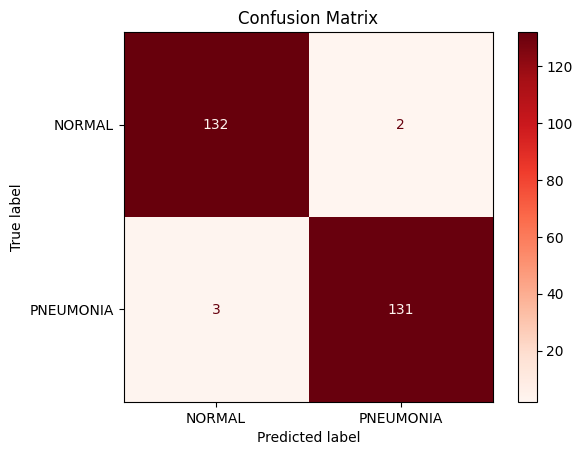

              precision    recall  f1-score   support

      NORMAL       0.98      0.99      0.98       134
   PNEUMONIA       0.98      0.98      0.98       134

    accuracy                           0.98       268
   macro avg       0.98      0.98      0.98       268
weighted avg       0.98      0.98      0.98       268



In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
testset = ImageFolder(root='/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=transform)
testloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Switch the model to evaluation mode
model.eval()

# Collect true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        preds = (outputs > 0.5).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Convert lists to numpy arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()

from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class AlbumentationsDataset(Dataset):
    def __init__(self, filepaths, labels, augment_function, class_names=None):
        self.filepaths = filepaths
        self.labels = labels
        self.augment_function = augment_function
        self.classes = class_names  # Class names for evaluation

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        label = self.labels[idx]

        # Apply augmentations
        if self.augment_function:
            image = self.augment_function(image=np.array(image))  # Call the provided augment function

        return image, label


class_names = ['Normal', 'Pneumonia']  # Replace with actual class names


from sklearn.metrics import classification_report

# Evaluate the model and populate predictions
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=testset.classes))


 <p style="padding:10px;background-color:green;margin:200;color:black;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 1500px 500px;overflow:hidden;font-weight:8000">Thanks for supporting me by upvotes😍🤝</p>